In [ ]:
# !pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121

In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu121
0.20.1+cu121


Generated random target pos in 6 iterations
Reward : 0.38566362857818604


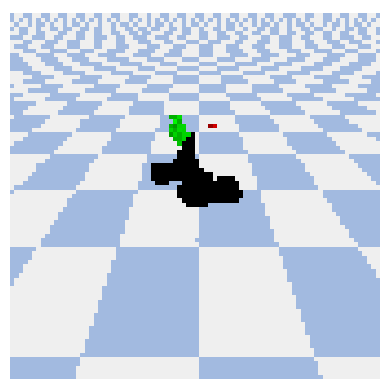

In [15]:
import importlib
import numpy as np
import matplotlib.pyplot as plt

import rx150_env 
importlib.reload(rx150_env)

from rx150_env import RX150Env 

urdf_path = "/interbotix_ros_manipulators/interbotix_ros_xsarms/interbotix_xsarm_descriptions/urdf/rx150.urdf"

# print(urdf_path)

rx_env = RX150Env(urdf_path,headless=True,image_height=84,image_width=84)

rx_env.reset()

action = np.random.choice([-1,0,1], size=5)
action = np.append(action,np.random.choice([0,1],size=1))

for _ in range(200):
    rx_env.step(action)

rx_img = rx_env.render()

rw,_ = rx_env.get_reward_and_terminal()
print(f"Reward : {rw}")

rx_env.close()

plt.imshow(rx_img)
plt.axis("off")
plt.show()

In [167]:
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

inputs = processor(text=["A 3D model of a robot arm and a red dot with a blue end-effector. The robot arm's blue end effector is touching the red dot","A 3D model of a robot arm and a red dot with a blue end-effector."], images=rx_img, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) 

with torch.no_grad():
    text_features = model.get_text_features(**{k: inputs[k] for k in ["input_ids", "attention_mask"]})
    image_features = model.get_image_features(**{k: inputs[k] for k in ["pixel_values"]})

text_features = text_features / text_features.norm(dim=-1, keepdim=True)
image_features = image_features / image_features.norm(dim=-1, keepdim=True)

similarity_score = (text_features @ image_features.T) 

print(similarity_score)

print(logits_per_image)
# print(probs)

tensor([[0.3104],
        [0.3134]])
tensor([[31.0354, 31.3393]], grad_fn=<TBackward0>)
